# Parameter Estimation, Enzyme Kinetics

Today, we have a challenging task.  We want to determine how long it will take for a 175L constant volume batch reactor (constructed from relatively low-grade steel) to achieve 85% conversion of a substrate (S) in an enzyme catalyzed reaction which is ultimately irreversible and has the following overall stoichiometry:

$$S\longrightarrow P$$

The initial concentration of substrate in the reactor is $C_{S0} = 8.6$ moles per liter. As far as we know, the enzyme catalyzed reaction follows a typical, Michaelis-Menten mechanism; however, the reaction appears to be inhibited by Chromium ions, which leach from the low-grade steel walls of the batch reactor over time. The rate of chromium leaching, in this system, is zero order and occurs with a ***rate constant of 0.0075 mol/L/s***.  We will use the symbol "I" to represent Chromium ions.  

This means that our overall rate expression for substrate conversion most likely has the following functional dependence:

$$r = f(C_S, C_I)$$

This means that it is important for us to know both substrate concentration and chromium concentration in order to determine the rate of reaction. At the outset, we do not know the rate law (reaction orders in substrate and Chromium ions), nor do we know any relevant kinetic parameters.  We will see if we can use our knowledge of enzyme catalyzed reactions along with experimental data to develop and parameterize a rate law so that we can solve our reactor design problem.

## Proposing a mechanism

We suspect that ***Chromium ions inhibit the reaction by binding directly with the enzyme***, which prevents it from binding substrate and ultimately slows down reaction kinetics.  We are always faced with some degree of Chromium leaching in this system, so it is important for us to account for the impact of chromium inhibition on the rate of reaction. From what we have speculated, the reaction mechanism should look something like this:

\begin{align*}
    E + S &\longleftrightarrow ES \\
    ES    &\longrightarrow     E + P \\
    E + I &\longleftrightarrow EI \\
\end{align*}

In class, we determined that **IF** an enzyme catalyzed reaction follows this mechanism, with this specific mode of inhibition, we should observe an overall rate law of:

$$r = \frac{V_{max}[S]}{[S] + K_m\left(1+K_3[I]\right)}$$

To assess whether this model accurately describes our system, we go into the lab and measure rates of reaction for various concentrations of the chromium ion inhibitor $[I] = [0.005, 0.1, 0.5, 1.25] \ \mathrm{M}$. Data are attached separately in the EXP1 to EXP4 csv files.

## Example Problem 01

1. Determine whether this mechanism accurately describes the data you have collected.
2. If it does not describe the data, revise the mechanism accordingly.
3. If it does describe the data, estimate the values of $V_{\mathrm{max}}$, $K_M$, and $K_3$.

### Solution to Example Problem 01

In the attached data, we have four separate experiments that measure the rate of reaction at various substrate concentrations for multiple inhibitor concentrations.  We'll load these in the cell below and plot the experiments to get a feel for the data.  Each EXP data file has two columns.  The first column is the substrate concentration (CS) in mol/L; the second concentration is the inhibitor concentration (CI) in mol/L; and the third column is the overall reaction rate (r) in units of mol/L/s.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp
import scipy.stats as stats
from scipy.interpolate import interp1d

#### Loading Experimental Data from .csv files

In [2]:
#################################################################################################
# Load experimental measurements for first problem into a data frame                            #
#################################################################################################

EXP1df = pd.read_csv("EXP1.csv", names = ["Substrate Concentration (mol/L)", "Chromium Ion Concentration (mol/L)", "rate (mol/L/s)"])
EXP2df = pd.read_csv("EXP2.csv", names = ["Substrate Concentration (mol/L)", "Chromium Ion Concentration (mol/L)", "rate (mol/L/s)"])
EXP3df = pd.read_csv("EXP3.csv", names = ["Substrate Concentration (mol/L)", "Chromium Ion Concentration (mol/L)", "rate (mol/L/s)"])
EXP4df = pd.read_csv("EXP4.csv", names = ["Substrate Concentration (mol/L)", "Chromium Ion Concentration (mol/L)", "rate (mol/L/s)"])

#################################################################################################
# Convert data frame to numpy array --> easier for elementwise math                             #
#################################################################################################

EXP1   = pd.DataFrame.to_numpy(EXP1df)
EXP2   = pd.DataFrame.to_numpy(EXP2df)
EXP3   = pd.DataFrame.to_numpy(EXP3df)
EXP4   = pd.DataFrame.to_numpy(EXP4df)

#################################################################################################
# Store CS, CI, and rate data for each experiment in separate numpy arrays                      #
#################################################################################################

CS1  = EXP1[:,0]
CI1  = EXP1[:,1]
r1   = EXP1[:,2]

CS2  = EXP2[:,0]
CI2  = EXP2[:,1]
r2   = EXP2[:,2]

CS3  = EXP3[:,0]
CI3  = EXP3[:,1]
r3   = EXP3[:,2]

CS4  = EXP4[:,0]
CI4  = EXP4[:,1]
r4   = EXP4[:,2]

In [5]:
# EXP1df

#### Graphing Raw Data

Instinctively, we might just plot rate against substrate concentration, but we'll see this isn't all that informative.  It will show us that increasing chromium ion concentration decreases the rate of reaction, but we can't say much about the mechanism of action based on this visualization.

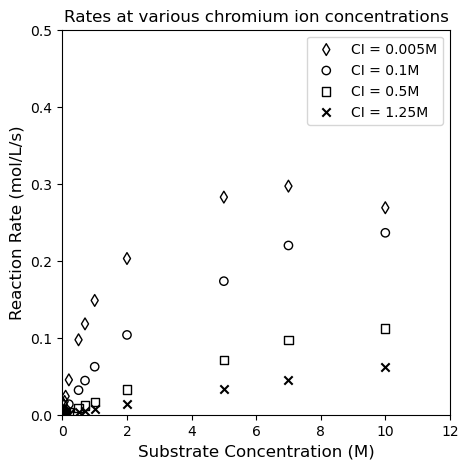

In [6]:
#####################################################################################################
# Create scatterplot of rate vs. CS for various inhibitor concentrations                            #
#####################################################################################################

plt.figure(1, figsize = (5, 5))
plt.scatter(CS3, r3, marker = 'd', color = 'none', edgecolor = 'black', label = 'CI = 0.005M')
plt.scatter(CS1, r1, marker = 'o', color = 'none', edgecolor = 'black', label = 'CI = 0.1M')
plt.scatter(CS2, r2, marker = 's', color = 'none', edgecolor = 'black', label = 'CI = 0.5M')
plt.scatter(CS4, r4, marker = 'x', color = 'black', label = 'CI = 1.25M')
plt.xlim(0, 12)
plt.ylim(0, 0.5)
plt.title('Rates at various chromium ion concentrations')
plt.xlabel('Substrate Concentration (M)', fontsize = 12)
plt.ylabel('Reaction Rate (mol/L/s)', fontsize = 12)
plt.legend()
plt.show()

#### Linearization of Model

It useful to try to linearize this data so that we can consider how the slope and/or intercept respond to changes in inhibitor concentration.  Specifically, we know that if the proposed mode of inhibition is true, and we have the following overall rate law:

$$r = \frac{V_{max}[S]}{[S] + K_m\left(1+K_3[I]\right)}$$

We can linearize by inverting the expression to get:

$$\frac{1}{r} = \frac{K_M(1 + K_{3_C}[I])}{V_\textrm{max}}\frac{1}{[S]} + \frac{1}{V_\textrm{max}}$$

If this mode of inhibition is correct, we should see each linearized data set having a constant y-intercept but varied slopes. Let's plot $1/r$ vs. $1/[S]$ for each inhibitor concentration and see how it looks.

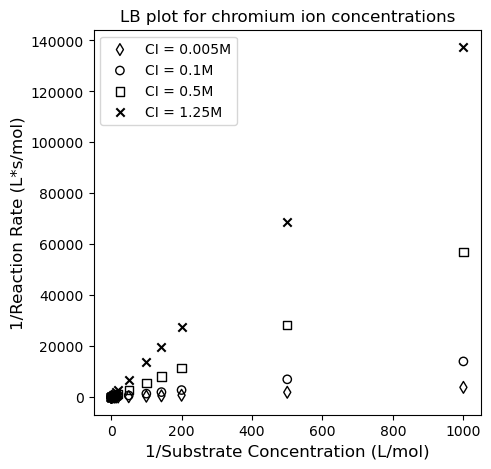

In [7]:
#########################################################################################################
# Lineweaver-Burk linearization for various inhibitor concentrations                                    #
#########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(1/CS3, 1/r3, marker = 'd', color = 'none', edgecolor = 'black', label = 'CI = 0.005M')
plt.scatter(1/CS1, 1/r1, marker = 'o', color = 'none', edgecolor = 'black', label = 'CI = 0.1M')
plt.scatter(1/CS2, 1/r2, marker = 's', color = 'none', edgecolor = 'black', label = 'CI = 0.5M')
plt.scatter(1/CS4, 1/r4, marker = 'x', color = 'black', label = 'CI = 1.25M')
plt.title('LB plot for chromium ion concentrations')
plt.xlabel('1/Substrate Concentration (L/mol)', fontsize = 12)
plt.ylabel('1/Reaction Rate (L*s/mol)', fontsize = 12)
plt.legend()
plt.show()

#### Linear Regression to Determine slopes and intercepts

It really looks like each of these are extrapolating to a common y-intercept (we'll have to regress to find out), and that they all have different slopes, which is consistent with the proposed mechanism of inhibition.  Below, we regress slopes and intercepts for each experiment and compare them.

In [8]:
#########################################################################################
# Fit a linear model to each 1/r vs. 1/CS data set; return coefficients                 #
#########################################################################################

coeffs1 = np.polyfit(1/CS1, 1/r1, 1)
coeffs2 = np.polyfit(1/CS2, 1/r2, 1)
coeffs3 = np.polyfit(1/CS3, 1/r3, 1)
coeffs4 = np.polyfit(1/CS4, 1/r4, 1)

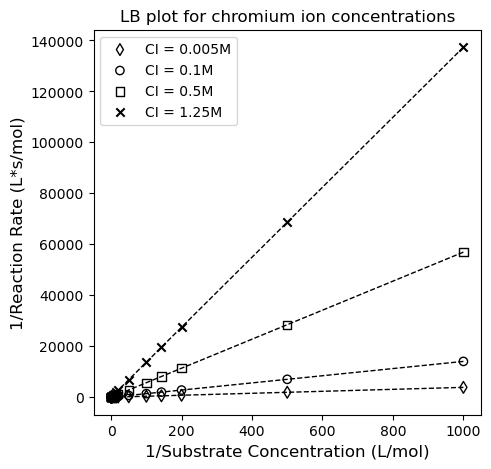

In [9]:
########################################################################################################
# Overlay regressed lines with data to visualize goodness of fit                                       #
########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(1/CS3, 1/r3, marker = 'd', color = 'none', edgecolor = 'black', label = 'CI = 0.005M')
plt.scatter(1/CS1, 1/r1, marker = 'o', color = 'none', edgecolor = 'black', label = 'CI = 0.1M')
plt.scatter(1/CS2, 1/r2, marker = 's', color = 'none', edgecolor = 'black', label = 'CI = 0.5M')
plt.scatter(1/CS4, 1/r4, marker = 'x', color = 'black', label = 'CI = 1.25M')
plt.plot(1/CS1, np.polyval(coeffs1, 1/CS1), color = 'black', linestyle = 'dashed', linewidth = 1, label = None)
plt.plot(1/CS2, np.polyval(coeffs2, 1/CS2), color = 'black', linestyle = 'dashed', linewidth = 1, label = None)
plt.plot(1/CS3, np.polyval(coeffs3, 1/CS3), color = 'black', linestyle = 'dashed', linewidth = 1, label = None)
plt.plot(1/CS4, np.polyval(coeffs4, 1/CS4), color = 'black', linestyle = 'dashed', linewidth = 1, label = None)
plt.title('LB plot for chromium ion concentrations')
plt.xlabel('1/Substrate Concentration (L/mol)', fontsize = 12)
plt.ylabel('1/Reaction Rate (L*s/mol)', fontsize = 12)
plt.legend()
plt.show()

#### Comparing Slopes and Intercepts

The linearized model fits our data very well.  Let's look at the regressed coefficients to see how they behave.

In [10]:
#############################################################################################################################
# Extract the slope (first element in coefficient array) and intercept (2nd element in coefficient array) for each data fit #
#############################################################################################################################

slopes = np.array([coeffs1[0], coeffs2[0], coeffs3[0], coeffs4[0]])
yints  = np.array([coeffs1[1], coeffs2[1], coeffs3[1], coeffs4[1]])

#############################################################################################################################
# Print values in each array for comparison; are the y-intercepts all the same?                                             #
#############################################################################################################################

print(slopes, '\n')
print(yints)

[ 14.05317747  56.93341744   3.86935058 137.3336761 ] 

[2.67140293 2.66694803 2.80912682 2.63485009]


From that, we can see that we have a roughly constant y-intercept whereas the regressed slopes vary with inhibitor concentration. This provides evidence that our proposed mechanism of inhibition is correct. Coinsulting the linearized model, we could use the average value of the y-intercept to estimate Vmax:

$$V_{max} = \frac{1}{\bar{b}}$$

Where $\bar{b}$ is the average y-intercept regressed in all of our Lineweaver-Burk plots.

In [11]:
Vmax_est = 1/np.mean(yints)
print(f'A rough estimate of Vmax is {Vmax_est:4.3f} mol/L/s')

A rough estimate of Vmax is 0.371 mol/L/s


Moreover, if we plot the values of the slope against inhibitor concentration, we can see that the slope varies linearly with inhibitor concentration.  This is what we expect; the slope of the LB linearizations follows the form below:

$$m = \frac{K_M + K_3[I]}{V_\textrm{max}}$$

Which is a straight line in disguise:

$$m = \frac{K_M}{V_\textrm{max}} + \frac{K_3}{V_\textrm{max}}[I]$$

If we plot the regressed slopes against inhibitor concentration, and we observe linearity, this is strong evidence that our proposed mechanism is correct.

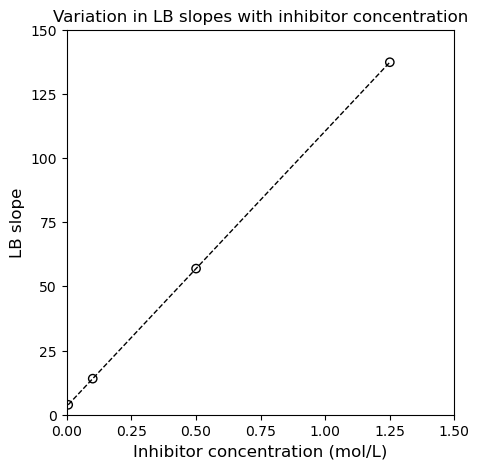

In [12]:
###################################################################################
# Create array of inhibitor concentrations from each experiment                   #
###################################################################################

inhibitors = np.array([CI1[0], CI2[0], CI3[0], CI4[0]])

###################################################################################
# Fit a line to slope vs. inhibitor concentration                                 #
###################################################################################

slopecoeff = np.polyfit(inhibitors, slopes, 1)

###################################################################################
# Plot slopes vs. inhibitor concentration; overlay line of best fit               #
###################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(inhibitors, slopes, color = 'none', edgecolor = 'black')
plt.plot(np.array([min(inhibitors), max(inhibitors)]), np.polyval(slopecoeff, np.array([min(inhibitors), max(inhibitors)])), color = 'black', linestyle = 'dashed', linewidth = 1)
plt.title('Variation in LB slopes with inhibitor concentration')
plt.xlabel('Inhibitor concentration (mol/L)', fontsize = 12)
plt.ylabel('LB slope', fontsize = 12)
plt.xlim(0, 1.5)
plt.ylim(0, 150)
plt.xticks(np.arange(0, 1.51, 0.25))
plt.yticks(np.arange(0, 151, 25))
plt.show()

Not only that, if we plot the slopes of the LB plot against $[I]$ and regress the line of best fit (considering that the equation that describes the data in the above figure):

$$m = \frac{K_M}{V_\textrm{max}} + \frac{K_3}{V_\textrm{max}}[I]$$

And we remember that we estimated $V_{\mathrm{max}}$ from the initial Lineweaver-Burk intercept, we can use this regression to get rough estimates for $K_M$ (from the intercept) and $K_3$ (from the slope).

In [13]:
Vmax_est = 1/np.mean(yints) #mol/L/s
KM_est   = slopecoeff[1]*Vmax_est #mol/L
K3_est   = slopecoeff[0]*Vmax_est #L/mol

print(f'Rough estimates for Vmax, KM, and K3 are {Vmax_est:3.3f} mol/L/s, {KM_est:3.3f} mol/L, and {K3_est:3.3f} L/mol')

Rough estimates for Vmax, KM, and K3 are 0.371 mol/L/s, 1.237 mol/L, and 39.769 L/mol


It is tempting to stop here since we have credible estimates for all of the parameters. Honestly, this would be a decent solution to the parameter estimation problem.  I do worry because in order to make these estimates of $K_M$ and $K_3$, we had to assume that we knew $V_{\mathrm{max}}$ exactly. That isn't true -- ***we really should regress all three parameters at the same time*** because there is uncertainty in our estimate of $V_{\mathrm{max}}$, and that impacts our precision in estimating $K_M$ and $K_3$.

We know of two ways to do this.

1. Nonlinear regression using the rate law above
2. Multiple linear regression using a linearized model

#### Nonlinear Regression

We'll perform nonlinear regression first since we are already familiar with the method. We can use `opt.minimize()` to minimize residual sum of squares as a function of $(K_M, K_3, \ \mathrm{and} \ V_\mathrm{max})$.

First, we will put all of our experiments into a single data set that compiles rates as a function of substrate and inhibitor concentration.  These will be our experimental measurements. Then, we'll use this model to calculate our predicted rates at each substrate and inhibitor concentration.  

$$r = \frac{V_{max}[S]}{[S] + K_m\left(1+K_3[I]\right)}$$

It will be a function of our 3 variable parameters: $K_M$, $V_\mathrm{max}$, and $K_3$.  Thus, we can use this approach to write an objective function that calculates the residual sum of squares as a function of $K_M$, $V_\mathrm{max}$, and $K_3$.  This is all implemented below.


```{caution}
We should remember how sensitive nonlinear regression is to the initial guesses for parameter values. We can use the rough approximations from above as initial guess. These will be refined using `opt.minimize()` in the course of nonlinear regression.
```

In [14]:
######################################################################################################
# Display current estimates for Vmax, KM, and K3; these are pretty good initial guesses!             #
######################################################################################################

print(f'Rough estimates for Vmax, KM, and K3 are {Vmax_est:3.3f} mol/L/s, {KM_est:3.3f} mol/L, and {K3_est:3.3f} L/mol')

Rough estimates for Vmax, KM, and K3 are 0.371 mol/L/s, 1.237 mol/L, and 39.769 L/mol


Nonlinear regression gives SSE = 0.038, Vmax = 0.343 mol/L/s, KM = 1.140 mol/L, K3 = 32.092L/mol


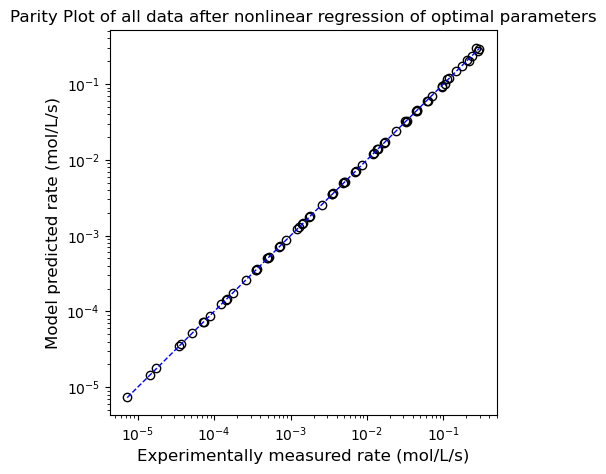

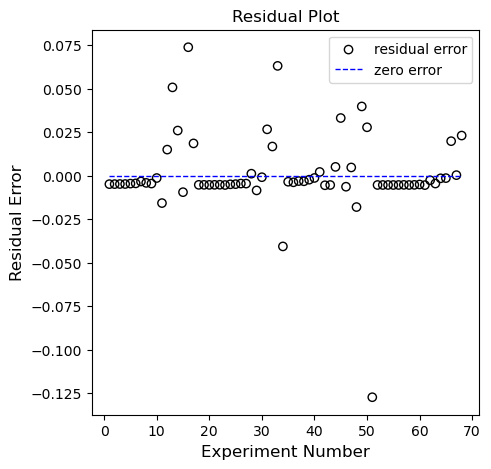

In [16]:
#########################################################################################################
# Combine all data into one array; more convenient for solving least squares problem                    #
#########################################################################################################

DATA   = np.vstack((EXP1, EXP2, EXP3, EXP4)) #arrange all experimental data as an m x 3 matrix.
CS_exp = DATA[:,0] #first column is substrate concentration
CI_exp = DATA[:,1] #second column is inhibitor concentration
r_exp  = DATA[:,2] #third column is the rate measured at current CS, CI

#########################################################################################################
# Define a helper function that takes par = [Vmax, KM, K3] as an argument                               #
# It will calculate and return SSE, r_exp, r_mod, and resid for a given par set                         #
#########################################################################################################

def temp2(par):
    Vmax, KM, K3 = par
    
    r_mod  = Vmax*CS_exp/(CS_exp + KM*(1 + K3*CI_exp))
    
    resid  = (r_exp - r_mod)/r_exp
    SSE    = np.sum(resid**2)
    return [SSE, r_exp, r_mod, resid]

#########################################################################################################
# Use the helper function to build an objective function that takes par as argument                     #
# for this one, we only need the SSE so it returns only temp2(par)[0]                                   #
#########################################################################################################

def obj2(par):
    return temp2(par)[0]

#########################################################################################################
# Define initial guesses for the variable parameters                                                    #
#########################################################################################################

par0    = [Vmax_est, KM_est, K3_est]

#########################################################################################################
# Optimize the objective function to find the par values that minimize SSE                              #
#########################################################################################################

ans2    = opt.minimize(obj2, par0)

#########################################################################################################
# Extract optimal parameter values from solution structure .x attribute                                 #
#########################################################################################################

Vmax_NL, KM_NL, K3_NL = ans2.x
par_opt = ans2.x

#########################################################################################################
# Pass the optimum parameter set to the helper function to calculate optimal SSE, r_exp, r_mod, resid   #
#########################################################################################################

SSE, r_exp, r_mod, resid = temp2(par_opt)

#########################################################################################################
# Display optimized results                                                                             #
#########################################################################################################

print(f'Nonlinear regression gives SSE = {SSE:3.3f}, Vmax = {Vmax_NL:3.3f} mol/L/s, KM = {KM_NL:3.3f} mol/L, K3 = {K3_NL:3.3f}L/mol')

#########################################################################################################
# generate parity plot of model predictions vs. experimental measurements                               #
#########################################################################################################

plt.figure(figsize = (5, 5))
plt.loglog(r_exp, r_mod, marker = 'o', markerfacecolor = 'none', markeredgecolor = 'black', linestyle = 'none')
plt.loglog([min(r_exp), max(r_exp)], [min(r_exp), max(r_exp)], color = 'blue', linestyle = 'dashed', linewidth = 1)
plt.title('Parity Plot of all data after nonlinear regression of optimal parameters')
plt.xlabel('Experimentally measured rate (mol/L/s)', fontsize = 12)
plt.ylabel('Model predicted rate (mol/L/s)', fontsize = 12)
plt.show()

#########################################################################################################
# Generate plot of residual errors vs. edata point number                                               # 
#########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(np.arange(1, len(r_exp)+1, 1), (r_exp - r_mod)/r_exp, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, 1, len(r_exp), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('Experiment Number', fontsize = 12)
plt.ylabel('Residual Error', fontsize = 12)
plt.title('Residual Plot')
plt.legend()
plt.show()

#### Multiple Linear Regression

The second way that we can estimate parameters is an extension of our tools for linear least squares and polynomial regression. We can generally refer to this method as multiple linear regression, and it requires that we have a convenient linearization for the data set. It isn't immediately obvious, but we can linearize this model. First, we work with the linearized form of the rate expression:

$$\frac{1}{r} = \frac{K_M(1 + K_{3_C}[I])}{V_\textrm{max}}\frac{1}{[S]} + \frac{1}{V_\textrm{max}}$$

But we can see that we could present this another way as being a linear function of both [I]/[S] and 1/[S]:

$$\frac{1}{r} = \frac{K_M}{V_\textrm{max}}\frac{1}{[S]} + \frac{K_MK_{3_C}}{V_\textrm{max}}\frac{[I]}{[S]}+ \frac{1}{V_\textrm{max}}$$

This is really just of the form:

$$Y = \alpha_0x_1 + \alpha_1x_2 + \alpha_3$$

We can put this into matrix form:

$$XA = Y$$

And use matrix algebra to solve for the unknown coefficients.  

Once we get the coefficients, we know that:

\begin{align}
    \alpha[0] = \frac{K_M}{V_\textrm{max}} \\
    \\
    \alpha[1] = \frac{K_MK_3}{V_\textrm{max}} \\
    \\
    \alpha[2] = \frac{1}{V_\textrm{max}} \\
\end{align}

From that, we can get good estimates of our 3 parameters.

[  3.33331918 107.20018591   2.69558197] 

R2 = 1.000
Vm = 0.371 mol/L/s
KM = 1.237 mol/L
K3 = 32.160 L/mol


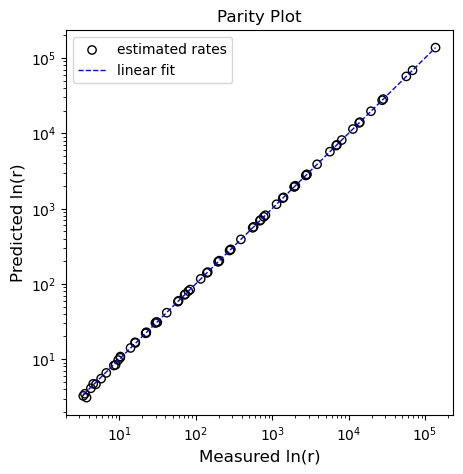

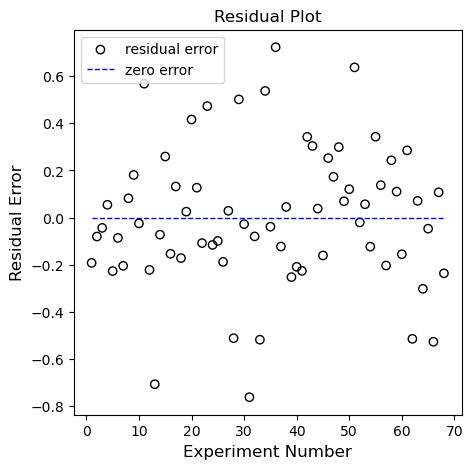

In [17]:
X      = np.ones((len(r_exp),3))       #Design matrix X
X[:,0] = 1/CS_exp
X[:,1] = CI_exp/CS_exp
Y      = 1/r_exp                 #Vector of observables, Y
A      = np.linalg.solve(X.T@X, X.T@Y) #Solve for unknown coefficiens, ln(k), α, β
SSE    = (Y - X@A).T@(Y-X@A)           #Residual sum of squares
SST    = sum((Y - np.mean(Y))**2)      #Total sum of squares
Ypred  = X@A
R2     = 1 - SSE/SST                   #R2
s2     = SSE/(len(Y) - len(A))         #Approximation for variance
cov    = s2*np.linalg.inv((X.T@X))     #covariance matrix
se     = np.sqrt(abs(cov))             #standard error matrix; diagonal elements are standard error for coeffs
ci     = stats.t.ppf(0.975, len(Y) - len(A))*se #confidence intervals
Ypred  = X@A   #predicted values of Y

Vmax_lin = 1/A[2]
KM_lin   = Vmax_lin*A[0]
K3_lin   = Vmax_lin/KM_lin*A[1]

print(A, '\n')
print(f'R2 = {R2:3.3f}')
print(f'Vm = {Vmax_lin:3.3f} mol/L/s')
print(f'KM = {KM_lin:3.3f} mol/L')
print(f'K3 = {K3_lin:3.3f} L/mol')

plt.figure(1, figsize = (5, 5))
plt.scatter(Y, Ypred, marker = 'o', color = 'none', edgecolor = 'black', label = 'estimated rates')
plt.plot([min(Y), max(Y)], [min(Y), max(Y)], color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Measured ln(r)', fontsize = 12)
plt.ylabel('Predicted ln(r)', fontsize = 12)
plt.title('Parity Plot')
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(np.arange(1, len(Y)+1, 1), (Y - Ypred), marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, 1, len(Y), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('Experiment Number', fontsize = 12)
plt.ylabel('Residual Error', fontsize = 12)
plt.title('Residual Plot')
plt.legend()
plt.show()

Before proceeding, let's compare the parameter estimates from NL and Linear Regression

In [ ]:
print(f'NL regression gives Vmax = {par_opt[0]:3.3f} mol/L/s, KM = {par_opt[1]:3.3f} mol/L, K3 = {par_opt[2]:3.3f}L/mol')
print(f'L  regression gives Vmax = {Vmax_lin:3.3f} mol/L/s, KM = {KM_lin:3.3f} mol/L, K3 = {K3_lin:3.3f}L/mol')

NL regression gives Vmax = 0.343 mol/L/s, KM = 1.140 mol/L, K3 = 32.092L/mol
L  regression gives Vmax = 0.371 mol/L/s, KM = 1.237 mol/L, K3 = 32.160L/mol


The estimates are close in either case.  I'm going to go ahead and use the ones from nonlinear regression hereafter.

## Example Problem 02

Now that we have a workable rate law, how long does it take to achieve 85% conversion in the originally described 175L Constant volume batch reactor if we operate with an initial substrate concentration of 8.6M.  The reactor is initially clean, and the aqueous solution we start with has no chromium initially; however, we do know that chromium ions enter solution at a rate of 0.0075 mol/L/s.

### Solution to Example Problem 02

This is just a matter of writing material balances on all species present in the reactor, of which we are interested in two (since they impact our rate law).  These are the concentration of substrate and the concentration of chromium ions.  The general material balance for a constant volume batch reactor is:

$$\frac{dC_j}{dt} = R_j$$

We can write one of these for the substrate concentration (CS) and one for the chromium concentration (CI).  

\begin{align}
    \frac{dC_S}{dt} = R_S \\
    \frac{dC_I}{dt} = R_I \\
\end{align}

We have to rate expressions that apply here; one is the overall rate of the enzymatic reaction (r1), and one is the rate of chromium leaching (r2):

\begin{align}
    r_1 &= \frac{V_{max}[S]}{[S] + K_m\left(1+K_3[I]\right)} \\
    \\
    r_2 &= 0.0075 \\
\end{align}

Both expressions give reaction rates in units of mol/L/s.

We can substitute these into our net production rate terms, $R_j$:

\begin{align}
    R_S &= -r_1 \\
    R_I &= r_2 \\
\end{align}

That should be enough to set up an ODE system and solve this problem numerically with `solve_ivp()`.  See below.

Achieving 85% conversion in this system requires a time of 76.190 seconds


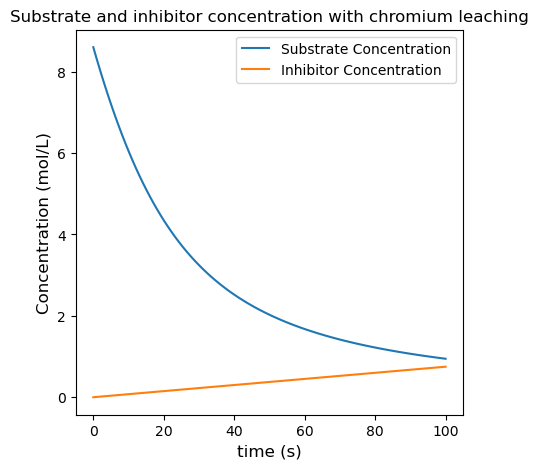

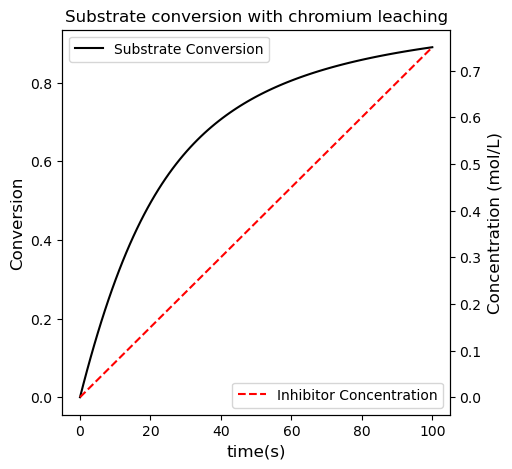

In [18]:
Vmax, KM, K3 = par_opt #using results from Nonlinear Regression

def P3(t, var):
    
    CS = var[0]
    CI = var[1]
    
    r1   = Vmax*CS/(CS + KM*(1+K3*CI)) #mol/L/s
    r2   = 0.0075 #mol/L/s
    
    RS   = -r1
    RI   =  r2
    
    D1 = RS
    D2 = RI
    return [D1, D2]

tspan  = (0, 100) #seconds
teval  = np.linspace(0, 100, 100)
CS0    = 8.6 #mol/L
CI0    = 0.0 #mol/L
C0     = [CS0, CI0] #initial concentration of substrate and inhibitor
ans3   = solve_ivp(P3, tspan, C0, atol = 1e-8, rtol = 1e-8, t_eval = teval)
t      = ans3.t
CS, CI = ans3.y
XS     = (CS0 - CS)/CS0 #true for a constant volume batch reactor
itp1   = interp1d(XS, t)

print(f'Achieving 85% conversion in this system requires a time of {itp1(0.85):3.3f} seconds')

plt.figure(1, figsize = (5, 5))
plt.plot(t, CS, label = 'Substrate Concentration')
plt.plot(t, CI, label = 'Inhibitor Concentration')
plt.title('Substrate and inhibitor concentration with chromium leaching')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('Concentration (mol/L)', fontsize = 12)
plt.legend()
plt.show()

#Create a second plot with a secondary y axis
fig2, ax1 = plt.subplots(figsize = (5, 5))
ax2 = ax1.twinx()
conversion, = ax1.plot(t, XS, color = 'black', label = 'Substrate Conversion')
inhibitor,  = ax2.plot(t, CI, color = 'red', linestyle = 'dashed', label = 'Inhibitor Concentration')

ax1.set_xlabel('time(s)', fontsize = 12)
ax1.set_ylabel('Conversion', fontsize = 12)
ax2.set_ylabel('Concentration (mol/L)', fontsize = 12)

ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')
plt.title('Substrate conversion with chromium leaching')
plt.show()

## Example Problem 03

How significant is the Chromium leaching anyway?  Let's figure out how long it would take to achieve 85% conversion of substrate if there was no chromium leaching in that reactor.

### Solution to Example Problem 03

Achieving 85% conversion in this system requires a time of 27.608 seconds


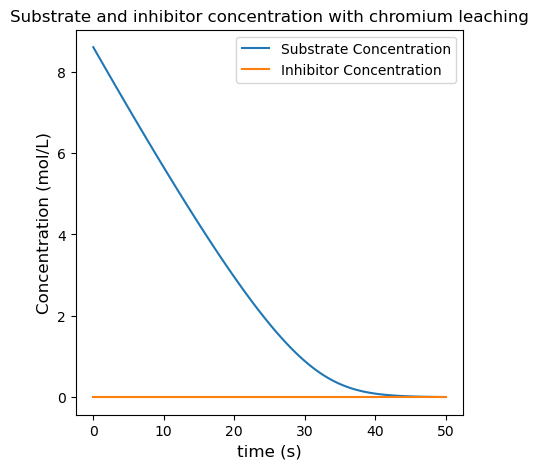

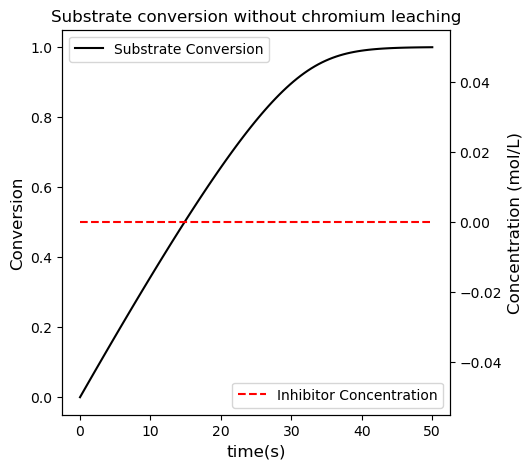

In [19]:
Vmax, KM, K3 = par_opt

def P3(t, var):
    
    CS = var[0]
    CI = var[1]
    
    r1   = Vmax*CS/(CS + KM*(1+K3*CI)) #mol/L/s
    r2   = 0 #mol/L/s
    
    RS   = -r1
    RI   =  r2
    
    D1 = RS
    D2 = RI
    return [D1, D2]

tspan  = (0, 50) #seconds
teval  = np.linspace(0, 50, 100)
C0     = [8.6, 0.0] #initial concentration of substrate and inhibitor
ans3   = solve_ivp(P3, tspan, C0, atol = 1e-8, rtol = 1e-8, t_eval = teval)
t      = ans3.t
CS, CI = ans3.y
XS     = (8.6 - CS)/8.6
itp1   = interp1d(XS, t)

print(f'Achieving 85% conversion in this system requires a time of {itp1(0.85):3.3f} seconds')

plt.figure(1, figsize = (5, 5))
plt.plot(t, CS, label = 'Substrate Concentration')
plt.plot(t, CI, label = 'Inhibitor Concentration')
plt.title('Substrate and inhibitor concentration with chromium leaching')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('Concentration (mol/L)', fontsize = 12)
plt.legend()
plt.show()

#Create a second plot with a secondary y axis
fig2, ax1 = plt.subplots(figsize = (5, 5))
ax2 = ax1.twinx()
conversion, = ax1.plot(t, XS, color = 'black', label = 'Substrate Conversion')
inhibitor,  = ax2.plot(t, CI, color = 'red', linestyle = 'dashed', label = 'Inhibitor Concentration')

ax1.set_xlabel('time(s)', fontsize = 12)
ax1.set_ylabel('Conversion', fontsize = 12)
ax2.set_ylabel('Concentration (mol/L)', fontsize = 12)

ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')
plt.title('Substrate conversion without chromium leaching')
plt.show()

## Example Problem 04

I wonder if glass would be a better choice for this reactor?

### Solution to Example Problem 04

Almost certainly...glass does not tend to corrode under most environments like a metal would, so it would not have any chromium leaching.  We would probably be able to cut batch times down significantly by working with a glass or glass-lined reactor here.